## 컨브넷을 사용한 시퀀스 처리
* **1D 컨브넷(1D convnet)**은 특정 시퀀스 처리 문제에서 RNN과 견줄 만하다.
* 일반적으로 계산 비용이 훨씬 싸다.
* 1D 컨브넷은 전형적으로 팽창된 커널(dilatedkernel)과 함께 사용된다.

### 시퀀스 데이터를 위한 1D 합성곱 이해하기
### 시퀀스 데이터를 위한 1D 폴링
### 1D 컨브넷 구현

In [2]:
from keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('data load...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequence')
print(len(x_test), 'test sequence')

print('sequence padding (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

data load...
25000 train sequence
25000 test sequence
sequence padding (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(
    optimizer=RMSprop(lr=1e-4),
    loss='binary_crossentropy', 
    metrics=['acc']
)
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 3

c:\Users\posky\anaconda3\envs\tf20\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


157/157 [==============================] - 6s 6ms/step - loss: 0.7980 - acc: 0.5126 - val_loss: 0.6865 - val_acc: 0.5582
Epoch 2/10
157/157 [==============================] - 1s 5ms/step - loss: 0.6735 - acc: 0.6298 - val_loss: 0.6679 - val_acc: 0.6444
Epoch 3/10
157/157 [==============================] - 1s 5ms/step - loss: 0.6380 - acc: 0.7196 - val_loss: 0.6287 - val_acc: 0.7010
Epoch 4/10
157/157 [==============================] - 1s 5ms/step - loss: 0.5652 - acc: 0.7871 - val_loss: 0.5269 - val_acc: 0.7812
Epoch 5/10
157/157 [==============================] - 1s 5ms/step - loss: 0.4430 - acc: 0.8352 - val_loss: 0.4334 - val_acc: 0.8308
Epoch 6/10
157/157 [==============================] - 1s 5ms/step - loss: 0.3637 - acc: 0.8667 - val_loss: 0.4062 - val_acc: 0.8452
Epoch 7/10
157/157 [==============================] - 1s 5ms/step - loss: 0.3211 - acc: 0.8844 - val_loss: 0.3948 - val_acc: 0.8576
Epoch 8/10
157/157 [==============================] - 1s 5ms/step - loss: 0.2930 - acc:

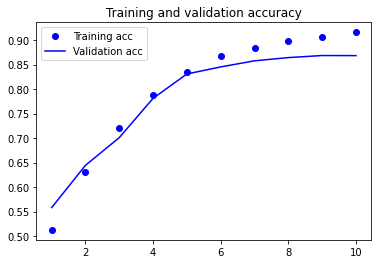

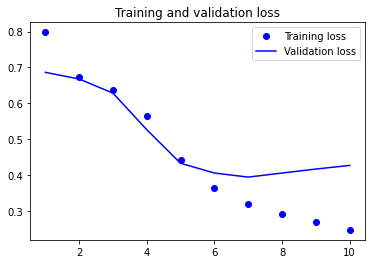

In [5]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### CNN과 RNN을 연결하여 긴 시퀀스를 처리하기
* 1D 컨브넷이 입력 패치를 독립적으로 처리하기 때문에 RNN과 달리 (합성곱 윈도우 크기의 범위를 넘어서는) 타임스텝의 순서에 만감하지 않는다.

In [6]:
import os
import numpy as np

DATA_PATH = os.path.join(os.environ['DEV_PATH'], 'datasets')

In [7]:
fname = os.path.join(DATA_PATH, 'jena_climate/jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [8]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [16]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [10]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [11]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(
    float_data,
    lookback=lookback, delay=delay,
    min_index=0, max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)
val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size
)
test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size
)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/20


C:\Users\posky\AppData\Local\Temp\ipykernel_22564\2217064254.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


500/500 [==============================] - 7s 12ms/step - loss: 0.4177 - val_loss: 0.4651
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3617 - val_loss: 0.4319
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3362 - val_loss: 0.4399
Epoch 4/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3211 - val_loss: 0.4673
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3070 - val_loss: 0.4639
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2969 - val_loss: 0.4629
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2870 - val_loss: 0.4539
Epoch 8/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2826 - val_loss: 0.5036
Epoch 9/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2758 - val_loss: 0.4735
Epoch 10/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2721 - val_loss: 0.4702


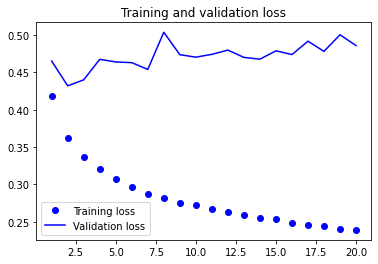

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 컨브넷의 속도와 경량함을 RNN의 순서 감지 능력과 결합하는 한 가지 전략은 1D 컨브넷을 RNN 이전에 전처리 단계로 사용하는 것이다.

In [17]:
step = 3
lookback = 1440
delay = 144

train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step
)
val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step
)
test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step
)
val_steps = (30000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, None, 32)          5152      
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
__________________________________________________

C:\Users\posky\AppData\Local\Temp\ipykernel_22564\358163740.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


500/500 [==============================] - 180s 357ms/step - loss: 0.3283
Epoch 2/20
500/500 [==============================] - 184s 367ms/step - loss: 0.2906
Epoch 3/20
500/500 [==============================] - 194s 388ms/step - loss: 0.2780
Epoch 4/20
500/500 [==============================] - 286s 572ms/step - loss: 0.2690
Epoch 5/20
500/500 [==============================] - 303s 605ms/step - loss: 0.2625
Epoch 6/20
500/500 [==============================] - 197s 394ms/step - loss: 0.2570
Epoch 7/20
500/500 [==============================] - 172s 345ms/step - loss: 0.2494
Epoch 8/20
500/500 [==============================] - 173s 345ms/step - loss: 0.2444
Epoch 9/20
500/500 [==============================] - 171s 342ms/step - loss: 0.2398
Epoch 10/20
500/500 [==============================] - 173s 346ms/step - loss: 0.2344
Epoch 11/20
500/500 [==============================] - 173s 345ms/step - loss: 0.2305
Epoch 12/20
500/500 [==============================] - 173s 346ms/step - l

### 정리
* 2D 컨브넷이 2D 공간의 시각적 패텬을 잘 처리하는 것처럼 1D 컨브넷은 시간에 따른 패턴을 잘 처리한다. 1D 컨브넷은 특성 자연어 처리 같은 일부 ㅊ몌제에 RNN을 대신할 수 있는 빠른 모델이다.
* 전혐적으로 1D 컨브넷은 컴퓨터 비전 분야의 2D 컨브넷과 비슷하게 구성한다. Conv1D 층과 Max-Pooling1D 층을 쌓고 마지막에 전역 플링 연산이나 Flatten 층을 둔다.
* RNN으로 아주 긴 시퀀스를 처리하려면 계산 비용이 많이 든다. 1D 컨브넷은 비용이 적게 든다. 따라서 1D 컨브넷을 RNN 이전의 전처리 단계로 사용하는 것은 좋은 생각이다. 시퀀스 길이를 줄이고 RNN이 처리할 유용한 표현을 추출해 줄 것이다.

## 요약
* 배운 기법
    * 텍스트를 토큰화하는 방법
    * 단어 임베딩과 이를 사용하는 방법
    * 순환 네트워크와 이를 사용하는 방법
    * 더 강력한 시퀀스 처리 모델을 만들기 의해 RNN 층을 스태킹하는 방법과 양방향 RNN을 사용하는 방법
    * 시퀀스를 처리하기 위해 1D 컨브넷을 사용하는 방법
    * 긴 시퀀스를 처라하기 위해 1D 컨브넷과 RNN을 연결하는 방법
* 시계열 데이터를 사용한 회귀(미래 값을 예측), 시계열 분류, 시계열에 있는 이상치 감지, 시퀀스 레이블링(문장에서 이름이나 날짜를 식별하기 등)에 RNN을 사용할 수 있다.
* 비슷하게 기계 변역(SliceNet 같은 시퀀스-투-시퀀스 합성곱 모델), 문서 분류, 맞춤법 정정 등에 1D 컨브넷을 사용할 수 있다.
* 시퀀스 데이터에서 전반적인 순서가 중요하다면 순환 네트워크를 사용하여 처리하는 것이 좋다. 최근의 정보가 오래된 과거보다 더 중요한 시계열 데이터가 전형적인 경우이다.
* 전반적인 순서가 큰 의미가 없다면 1D 컨브넷이 적어도 동일한 성능을 내면서 비용도 적을 것이다. 텍스트 데이터가 종종 이에 해당한다. 문장 처음에 있는 키워드가 마지막에 있는 키워드와 같은 의미를 가진다.